# COCO
> Detail API

In [1]:
#|default_exp coco

In [2]:
#| export
from avcv._imports import *

In [3]:
#| export
PYTHON_VERSION = 3


class AvCOCO(coco.COCO):
    def __init__(self, annotation_file=None, verbose=False):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        # load dataset
        self.dataset,self.anns,self.cats,self.imgs = dict(),dict(),dict(),dict()
        self.imgToAnns, self.catToImgs = defaultdict(list), defaultdict(list)
        self.verbose = verbose
        if not annotation_file == None:
            if verbose:
                logger.info('loading annotations into memory...')
            tic = time.time()
            if isinstance(annotation_file, str):
                with open(annotation_file, 'r') as f:
                    dataset = json.load(f)
            else:
                dataset = annotation_file
            assert type(dataset)==dict, 'annotation file format {} not supported'.format(type(dataset))
            if verbose:
                logger.info('Done (t={:0.2f}s)'.format(time.time()- tic))
            self.dataset = dataset
            self.createIndex()
            
            
    def createIndex(self):
        # create index
        if self.verbose:
            logger.info('creating index...')
        anns, cats, imgs = {}, {}, {}
        imgToAnns,catToImgs = defaultdict(list),defaultdict(list)
        if 'annotations' in self.dataset:
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']].append(ann)
                anns[ann['id']] = ann

        if 'images' in self.dataset:
            for img in self.dataset['images']:
                imgs[img['id']] = img

        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat

        if 'annotations' in self.dataset and 'categories' in self.dataset:
            for ann in self.dataset['annotations']:
                catToImgs[ann['category_id']].append(ann['image_id'])
        if self.verbose:
            logger.info('index created!')

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.catToImgs = catToImgs
        self.imgs = imgs
        self.cats = cats

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = coco.COCO()
        res.dataset['images'] = [img for img in self.dataset['images']]
        if self.verbose:
            logger.info('Loading and preparing results...')
        tic = time.time()
        if type(resFile) == str or (PYTHON_VERSION == 2 and type(resFile) == unicode):
            with open(resFile) as f:
                anns = json.load(f)
        elif type(resFile) == np.ndarray:
            anns = self.loadNumpyAnnotations(resFile)
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [ann['image_id'] for ann in anns]
        assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
               'Results do not correspond to current coco set'
        if 'caption' in anns[0]:
            imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
            res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
            for id, ann in enumerate(anns):
                ann['id'] = id+1
        elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                bb = ann['bbox']
                x1, x2, y1, y2 = [bb[0], bb[0]+bb[2], bb[1], bb[1]+bb[3]]
                if not 'segmentation' in ann:
                    ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
                ann['area'] = bb[2]*bb[3]
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'segmentation' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                # now only support compressed RLE format as segmentation results
                ann['area'] = maskUtils.area(ann['segmentation'])
                if not 'bbox' in ann:
                    ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
                ann['id'] = id+1
                ann['iscrowd'] = 0
        elif 'keypoints' in anns[0]:
            res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
            for id, ann in enumerate(anns):
                s = ann['keypoints']
                x = s[0::3]
                y = s[1::3]
                x0,x1,y0,y1 = np.min(x), np.max(x), np.min(y), np.max(y)
                ann['area'] = (x1-x0)*(y1-y0)
                ann['id'] = id + 1
                ann['bbox'] = [x0,y0,x1-x0,y1-y0]
        if self.verbose:
            logger.info('DONE (t={:0.2f}s)'.format(time.time()- tic))

        res.dataset['annotations'] = anns
        res.createIndex()
        return res        
        
        


In [4]:
#| export
from avcv.visualize import bbox_visualize, show as av_show

class CocoDataset:
    def __init__(self, gt, img_dir=None, pred=None, verbose=False):
        if img_dir is None:
            assert isinstance(gt, str) and '/annotations/' in gt
            img_dir = gt.split('/annotations/')[0]+'/images'
            if verbose:
                logger.warning(f'Img dir is not set, set to :{img_dir}')
            # assert osp.isdir(img_dir)
            
        if isinstance(gt, coco.COCO):
            gt = gt.dataset
        self.gt = AvCOCO(gt, verbose=verbose)

        if isinstance(pred, str):
            pred = mmcv.load(pred)

        self.pred = self.gt.loadRes(pred) if pred is not None else None

        self.img_dir = img_dir
        self.img_ids = [_['id'] for _ in self.gt.imgs.values()]

    def imread(self, img_id, channel_order='bgr'):
        im = self.gt.imgs[img_id]
        img_path = osp.abspath(osp.join(self.img_dir,im['file_name']))
        assert osp.exists(img_path), img_path
        return mmcv.imread(img_path, channel_order=channel_order)

    def visualize(self, img_id=None,  mode='gt', dpi=100, 
        show=False, anns=None, color='green', img=None, score_thr=0.3, box_color=None):
        if img_id is None:
            img_id = np.random.choice(self.img_ids)
            logger.info(f'Random visualize img_id={img_id}')
        if img is None:
            img= self.imread(img_id)

        if mode=='pred':
            assert self.pred is not None

        CLASSES = {cat_id:cat['name'] for cat_id, cat in self.gt.cats.items()}
        im = self.gt.imgs[img_id]
        source = self.pred if mode == 'pred' else self.gt

        if anns is None:
            anns  = source.loadAnns(source.getAnnIds(im['id']))

        bboxes = []
        lables = []
        scores = []
        for ann in anns:
            x1,y1,w,h = [int(_) for _ in ann['bbox']]
            x2 = x1+w
            y2 = y1+h
            scores.append(ann.get('score', 1))
            bboxes.append([x1,y1,x2,y2])
            lables.append(ann['category_id'])

        bboxes = np.array(bboxes)
        lables = np.array(lables)

        if len(bboxes):
            
            img = bbox_visualize(img, bboxes, scores, lables, score_thr, CLASSES, box_color=box_color)
#             img = mmcv.visualization.imshow_det_bboxes(img, bboxes, 
#                 lables, CLASSES, show=False, bbox_color=color, text_color=color, 
#                 score_thr=score_thr)
        if show:
            av_show(img[...,::-1], dpi=dpi)
        return img

    def load_anns(self, img_id, source=None):
        if source is None:
            source = self.gt
        anns = source.loadAnns(source.getAnnIds(img_id))
        return anns

    def evaluate(self, *args, **kwargs):
        cocoEval = COCOeval(self.gt, self.pred, 'bbox')
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

2022-11-25 08:34:52.721 | INFO     | __main__:visualize:35 - Random visualize img_id=49658
/home/anhvth8/.conda/envs/trans/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


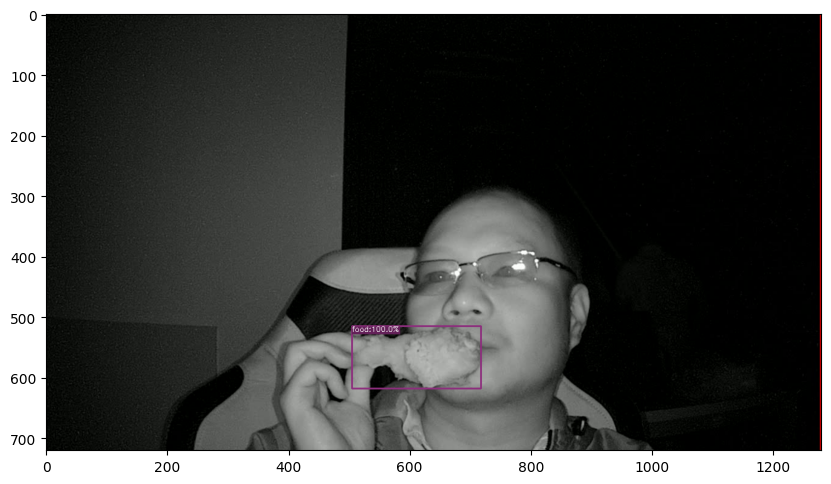

array([[[127, 130, 128],
        [  0,   3,   1],
        [  1,   4,   2],
        ...,
        [  0,   0,   0],
        [  1,   0, 202],
        [  5,   2, 206]],

       [[129, 132, 130],
        [  9,  12,  10],
        [  3,   6,   4],
        ...,
        [  0,   0,   0],
        [  1,   0, 202],
        [  5,   2, 206]],

       [[129, 132, 130],
        [ 15,  18,  16],
        [  3,   6,   4],
        ...,
        [  0,   0,   0],
        [  1,   0, 202],
        [  5,   2, 206]],

       ...,

       [[126, 129, 127],
        [  0,   3,   1],
        [  0,   0,   0],
        ...,
        [  1,   0,   2],
        [  0,   0, 199],
        [  0,   0, 200]],

       [[125, 128, 126],
        [  6,   9,   7],
        [  2,   5,   3],
        ...,
        [  1,   0,   2],
        [  0,   0, 199],
        [  0,   0, 200]],

       [[123, 126, 124],
        [ 10,  13,  11],
        [  7,  10,   8],
        ...,
        [  1,   0,   2],
        [  0,   0, 199],
        [  0,   0, 200]]

In [5]:
#| hide
cc = CocoDataset('/data/ActionObjects/LabeledVersionPng/annotations/val.json')
cc.visualize(show=1)

### BBox utils

In [6]:
#| export
def get_bboxes(anns,category_ids,
               mode='xywh',
               dtype=np.float32,
               score_thr=None, with_score=False):
    bboxes = []
    for ann in anns:
        if category_ids is not None and  not ann['category_id'] in category_ids: continue
        if score_thr is not None and ann.get('score', False):
            if ann['score'] < score_thr:
                continue
        x, y, w, h = ann['bbox']
        
        score = ann.get('score', 1)
        if mode == 'xywh':
            bboxes.append([x, y, w, h, score])
        elif mode == 'xyxy':
            bboxes.append([x, y, x + w, y + h, score])
        elif mode == 'cxcywh':
            cx = x + w / 2
            cy = y + h / 2
            bboxes.append([cx, cy, w, h, score])
        else:
            raise NotImplemented
    bboxes = np.array(bboxes).reshape([-1, 5])
    if not with_score:
        bboxes = bboxes[:,:4]
        
    if dtype is not None:
        bboxes = bboxes.astype(dtype)
    return bboxes


def get_overlap_rate(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    iou = interArea / float(boxAArea)
    return iou


def bbox_expand(bb, im_h, im_w, r=1.25):
    x,y,w,h = bb
    cx = x+w/2
    cy = y+h/2
    h*=r
    w*=r
    
    x1 = cx-w/2
    y1 = cy-h/2
    x2 = x1+w
    y2 = y1+h
    
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(im_w, x2)
    y2 = min(im_h, y2)
    
    return x1, y1, x2-x1, y2-y1


## DiagnoseCoco

In [7]:
#| export
class DiagnoseCoco(CocoDataset):
    COLORS = dict(
        TP=(0, 255, 0),
        FN=(0, 0, 255), # Undetected GT
        FP=(0,255,255), # Wrong detection
    )

    def find_false_samples(self, img_id, score_thr=0.05, visualize=True):
        assert self.gt is not None
        assert self.pred is not None
        pred_anns = [ann for ann in self.pred.loadAnns(self.pred.getAnnIds(img_id)) if ann['score']>score_thr]
        gt_anns = self.gt.loadAnns(self.gt.getAnnIds(img_id))

        pred_bboxes = get_bboxes(pred_anns,None , mode='xyxy')

        gt_bboxes = get_bboxes(gt_anns, None,mode='xyxy')
        with torch.no_grad():
            ious = bbox_overlaps(pred_bboxes, gt_bboxes).cpu().numpy()
        mapping_gt_pred = np.where(ious>0)

        result = dict(tp=[], fn=[], fp=[])

        gt_ids = list(range(len(gt_anns)))
        pred_ids = list(range(len(pred_anns)))
        for pred_id, gt_id in zip(*mapping_gt_pred):
            if gt_anns[gt_id]['category_id'] == pred_anns[pred_id]['category_id']:
                result['tp'].append(pred_anns[pred_id])
                if gt_id in gt_ids:
                    gt_ids.remove(gt_id)
                if pred_id in pred_ids:
                    pred_ids.remove(pred_id)


        result['fp'] = [pred_anns[i] for i in  pred_ids]
        result['fn'] = [gt_anns[i] for i in gt_ids]
        if visualize:
            vis_img = self.visualize(img_id, anns=result['fn'], color=self.COLORS['FN'], show=False, box_color=self.COLORS['FN'])
            vis_img = self.visualize(img_id,  anns=result['tp'],img=vis_img, show=False,box_color=self.COLORS['TP'])
            vis_img = self.visualize(img_id, anns=result['fp'], dpi=150,color=self.COLORS['FP'], show=False,
                                     img=vis_img, box_color=self.COLORS['FP'])
            vis_img = vis_img[...,::-1].copy()
            result['vis_img'] = vis_img
        return result
    
    def imshow(self, img_id, score_thr=0.05, **show_kwargs):
        img = self.find_false_samples(img_id, score_thr)['vis_img']
        show(img, **show_kwargs)

# Utils
## Video To Coco

In [8]:
#| export
def _f(p):
    img = mmcv.imread(p)
    mmcv.imwrite(img, p.replace('.png', '.jpg'))
    os.remove(p)
    
def to_jpg(img_dir):
    paths = glob(osp.join(img_dir, '*.png'))
    logger.info(f'Converting folder {img_dir} to jpg...')
    with Pool(10) as p:
        it = p.imap(_f, paths)
        total = len(paths)
        r = list(tqdm(it, total=total))

def video_to_coco(
    input_video,
    test_json,
    output_dir=None,
    skip=1,
    rescale=None,
    recursive=False,
    min_is_done_extracted_ratio=.7,
):

    assert os.path.exists(input_video), f'{input_video} does not exist'
    try:
        fps = mmcv.VideoReader(input_video).fps
    except:
        fps = None
        
    def path2image(path, root_dir):
        w, h = Image.open(path).size
        name = path.replace(root_dir, '')
        if name.startswith('/'):
            name = name[1:]
        return dict(
            file_name=name, height=h, width=w
        )
    

    if output_dir is None:
        name  = get_name(input_video) if not osp.isdir(input_video) else \
            os.path.normpath(input_video).split('/')[-1]
        output_dir = osp.join('.cache/video_to_coco', name)
        logger.info(f'Set output dir to->{output_dir}')

    image_out_dir = osp.join(output_dir, 'images')

    image_dir_name = osp.normpath(image_out_dir).split('/')[-1]
    path_out_json = osp.join(output_dir, f'annotations/{image_dir_name}.json')

    mmcv.mkdir_or_exist(osp.dirname(path_out_json))

    source_type = 'dir' if osp.isdir(input_video) else 'video'
    
    if not osp.isdir(input_video): # IF VIDEO => EXTRACT IMAGES to image_out_dir
        mmcv.mkdir_or_exist(image_out_dir)
        video = mmcv.VideoReader(input_video)
        

        if rescale is not None:
            _im = mmcv.imrescale(video[0], rescale)
            im_h, im_w = _im.shape[:2]#int(rescale*im_h), int(rescale*im_w)
        else:
            im_h, im_w = video[0].shape[:2]
        num_found_imgs = len(glob(osp.join(image_out_dir, '*.jpg')))
        is_done_extracted = (num_found_imgs / len(video)) > min_is_done_extracted_ratio
        if not num_found_imgs  == len(video):
            logger.warning(f'Differ num of extracted images and video len {num_found_imgs=}, {len(video)=}, {is_done_extracted=}')
        
        
        if not is_done_extracted:
            mmcv.mkdir_or_exist(image_out_dir)
            cmd = f"ffmpeg  -i {input_video} -s {im_w}x{im_h} {image_out_dir}/%06d.png"
            logger.info(f'Running command: {cmd}')
            os.system(cmd)
            to_jpg(image_out_dir)
        else:
            logger.info('Skip extracting video')
        
    else:
        # IF FOLDER THEN CREATE SYMLINK
        logger.info(f'Symn link {input_video}-> {image_out_dir}')
        os.symlink(osp.abspath(input_video), osp.abspath(image_out_dir))
        
    paths = list(sorted(glob(osp.join(image_out_dir, '*.jpg'), recursive=recursive)))
    paths += list(sorted(glob(osp.join(image_out_dir, '*.png'), recursive=recursive)))
    out_dict = dict(images=[], annotations=[], meta=dict(fps=fps),
                    categories=mmcv.load(test_json)['categories'])
    out_dict['images'] = list(
        map(partial(path2image, root_dir=image_out_dir), paths))

    for i, image in enumerate(out_dict['images']):
        image['id'] = i
    mmcv.dump(out_dict, path_out_json)
    return os.path.normpath(path_out_json), os.path.normpath(image_out_dir)




# CocoUtils

## concat_coco

In [9]:
#| export
def split_coco(coco, train_ratio=0.85, seed=0):
    if isinstance(coco, dict):
        coco = AvCOCO(coco)
    ids = list(coco.imgs.keys())
    np.random.seed(seed)
    np.random.shuffle(ids)
    train_n = int(len(ids)*train_ratio)
    train_ids = ids[:train_n]
    test_ids = ids[train_n:]
    logger.info('Spliting ratio {} -> {} training and {} testing'.format(train_ratio, len(train_ids), len(test_ids)))
    
    # train_ds = coco.dataset.copy()
    # val_ds = coco.dataset.copy()
    def get_ds(ids):
        out = dict(categories=coco.dataset['categories'], images=[], annotations=[])
        for img_id in ids:
            out['images'].append(coco.imgs[img_id])
            out['annotations'].extend(coco.imgToAnns[img_id])
        return out
    return get_ds(train_ids), get_ds(test_ids)


def concat_coco(datasets, new_root, name=None, cat_name2id=None, categories=None, strict_image_path=True):
    """
        Example:
            concat_coco([
                (train_ds_1, '/data/full-version-vip-pro/DMS_DB_090922/'),
                (train_ds_2, '/data/DMS_Behavior_Detection/merge-phone-cigaret-food/images'),

            ], '/data/face_food_concat/', 'train');
        """
    if cat_name2id is None:
        all_cat_name = []
        for dataset in datasets:
            av_coco = AvCOCO(dataset[0])
            all_cat_name.extend(
                [cat['name'].lower() for cat in av_coco.cats.values()])

        all_cat_name = list(set(all_cat_name))
        cat_name2id = {name: i + 1 for i, name in enumerate(all_cat_name)}
        # cat = {name:i+1 for i, name in enumerate(all_cat_name)}
        # import ipdb; ipdb.set_trace()
        print(f'New {cat_name2id=}')

    mmcv.mkdir_or_exist(osp.join(new_root, 'annotations'))
    out_concat = dict(images=[],
                      annotations=[],
                      categories=[
                          dict(name=name, id=id)
                          for name, id in cat_name2id.items()
                      ] if categories is None else categories)
    CACHE_IMAGE_PATH2ID = {}
    def get_image_id(image_path):
        image_path = osp.abspath(image_path)
        if not image_path in CACHE_IMAGE_PATH2ID:
            CACHE_IMAGE_PATH2ID[image_path] = len(CACHE_IMAGE_PATH2ID)+1
            
        return CACHE_IMAGE_PATH2ID[image_path]
        
    added_image_ids = set()
    
    for i, inp in enumerate(datasets):
        if not isinstance(inp, tuple):
            datasets[i] = (inp, inp.split('/annotations/')[0]+'/images')
    
    for json_path, old_img_dir in datasets:

        if isinstance(json_path, str) or isinstance(json_path, dict):
            dataset = AvCOCO(json_path)
        else :
            dataset = json_path
        for img_id in dataset.imgs:
            image = dataset.imgs[img_id]
            anns = dataset.imgToAnns[
                image['id']] if img_id in dataset.imgToAnns else []

            old_path = osp.join(old_img_dir, image['file_name'])
            old_path = osp.abspath(old_path)
            if strict_image_path:
                assert osp.exists(old_path), old_path
            image['file_name'] = osp.relpath(old_path,
                                             osp.join(new_root, 'images'))
            
            image['id'] = get_image_id(old_path)
            for ann in anns:
                cat_name = dataset.cats[ann['category_id']]['name']
                ann['category_id'] = cat_name2id[cat_name.lower()]
                ann['image_id'] = image['id']
                w, h = ann['bbox'][-2:]
                ann['area'] = w * h
                ann['id'] = len(out_concat['annotations'])

                out_concat['annotations'].append(ann)
                
            if not image['id'] in added_image_ids:
                valid_classes = set([cat['name'] for cat in dataset.cats.values()]) if not 'pred_' in json_path else None
                image['valid_classes'] = valid_classes
                out_concat['images'].append(image)
                added_image_ids.add(image['id'])

    if name is not None:
        out_json_path = osp.join(new_root, f'annotations/{name}.json')
        logger.info('Dump->{}', out_json_path)
        check_save_coco_dict(out_concat)
        mmcv.dump(out_concat, out_json_path)
    return out_concat


def check_save_coco_dict(data):
    def check_duplicated_id(name):
        ids = set()
        for item in data[name]:
            if not item['id'] in ids:
                ids.add(item['id'])
            else:
                print(f'{name}, Id: {id} is duplicated, item: {item}')
                return False
        return True
    if check_duplicated_id('images') and check_duplicated_id('annotations') and check_duplicated_id('categories'):
        print('This dict is cocoly safe')
        return True
    return False

def extract_coco(coco, img_ids):
    if isinstance(coco, dict) or isinstance(coco, str):
        coco = AvCOCO(coco)
    imgs = coco.loadImgs(img_ids)
    anns = coco.loadAnns(coco.getAnnIds(img_ids))
    return dict(images=imgs, annotations=anns, categories=coco.dataset['categories'])


## Example

## CLI

In [10]:
#| export
@call_parse
def v2c(input_video: Param("path to video", str),
        test_json: Param("path to annotation json path, to get the category", str),
        output_dir: Param("", str) = None,
        skip: Param("", int) = 1,        rescale: Param("", int) = None, recursive: Param("Images recursive", bool)=False
        ):
    return video_to_coco(input_video, test_json, output_dir, skip, rescale=rescale, recursive=recursive)


# BUILD

In [11]:
!nbdev_export